In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import normaltest
from scipy.stats import norm
import os

#set precision for displaying float-point values in the notebook
pd.options.display.float_format = '{:,.3f}'.format

This is a Python 3 notebook, which, together with `data_reader.py` provides the idea of how the pilot data was pre-processed

In [7]:
import data_reader

def save_processed_data(data_path):    
    dr = data_reader.DataReader()
    choices, dynamics = dr.read_data(path=data_path)
    choices, dynamics = dr.preprocess_data(choices, dynamics)

    choices['Lambda'] = np.log(choices.LL_advantage)
    choices['Lambda_quintile'] = pd.qcut(choices.Lambda, 4, labels=False)
    choices['log_RT'] = np.log(choices.RT)
    choices['inv_RT'] = 1/(choices.RT)
    choices['log_delay'] = np.log(choices.ll_delay)
    
    # in the pilot data, two such trials are excluded, both RT>7
    choices = choices[(choices.RT>2)&(choices.RT<7)]

    choices.to_csv(os.path.join(data_path, 'choices_processed.csv'), index=False, float_format='%.3f')
    
data_path = 'D:/data/beyond_the_reach/pilot_and _power_analysis/pilot'
save_processed_data(data_path)

C:\Users\Arkady\Dropbox\Research\DECIDE\DMWalkers\data_reader.py:61: FutureWarning: 'subj_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  end_points = dynamics.groupby(by=self.index).last()
C:\Users\Arkady\Dropbox\Research\DECIDE\DMWalkers\data_reader.py:61: FutureWarning: 'trial_no' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  end_points = dynamics.groupby(by=self.index).last()


In [8]:
choices = pd.read_csv(os.path.join(data_path, 'choices_processed.csv'), sep=',', index_col=['subj_id', 'trial_no'])
    
choices_sc = choices[choices.is_staircase]
choices_mcq = choices[~choices.is_staircase]

Here we check whether the dynamical DV's are normally distributed

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


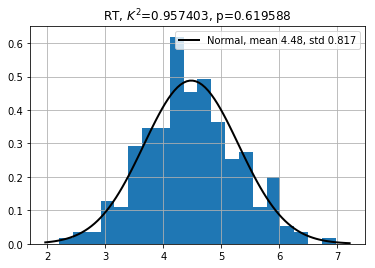

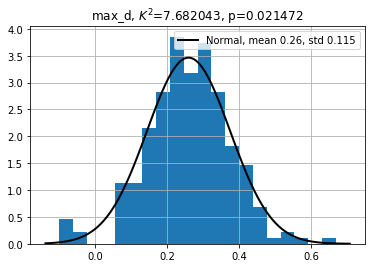

In [9]:
def fit_norm(data): 
    plt.figure()
    data.hist(bins=20, normed=True)
    mu, std = norm.fit(data)    
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2, label='Normal, mean %.2f, std %.3f' % (mu, std))
    plt.title(data.name)
    plt.title('%s, $K^2$=%f, p=%f' % (data.name, normaltest(data)[0], normaltest(data)[1]))
    plt.legend()
    plt.savefig('%s.png' % (data.name))
    
fit_norm(choices.RT)
fit_norm(choices.max_d)

In [5]:
choices.columns

Index(['is_staircase', 'ss_delay', 'ss_amount', 'll_delay', 'll_amount', 'RT',
       'idx_max_d', 'max_d', 'ss_chosen', 'choice', 'chosen_amount',
       'chosen_delay', 'amount_ratio', 'amount_diff', 'amount_increase',
       'LL_advantage', 'type', 'max_d_z', 'Lambda', 'Lambda_quintile',
       'log_RT', 'inv_RT', 'log_delay'],
      dtype='object')

# Potentially useful plots and code

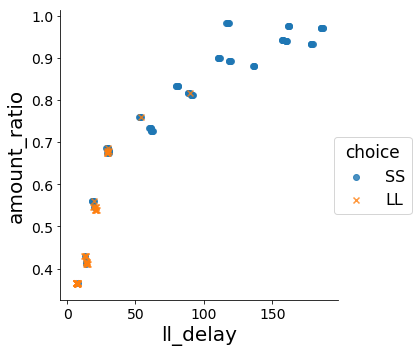

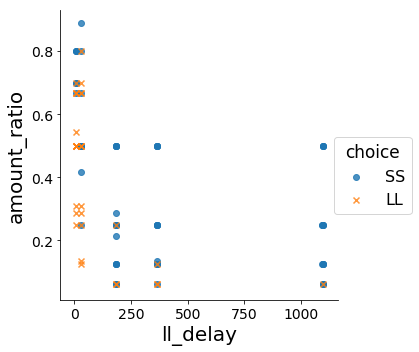

In [19]:
sns.lmplot(x='ll_delay', y='amount_ratio', hue='choice', data=choices_mcq, fit_reg=False, x_jitter=1, markers=['o', 'x'])
sns.lmplot(x='ll_delay', y='amount_ratio', hue='choice', data=choices_sc, fit_reg=False, x_jitter=1, markers=['o', 'x'])

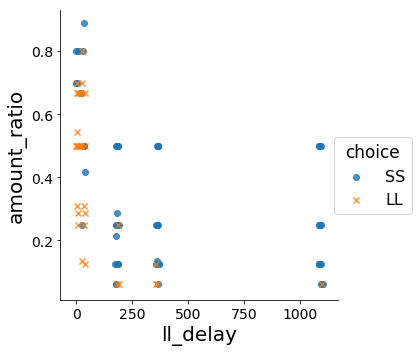

In [34]:
# tmp = choices[(choices.ll_delay<1000) & (choices.is_staircase)]
# tmp['delay_norm'] = tmp['ll_delay']/tmp['ll_delay'].max()
sns.lmplot(x='ll_delay', y='amount_ratio', hue='choice', data=choices_sc, fit_reg=False, x_jitter=10, markers=['o', 'x'])
# choices['delay_norm'].describe()

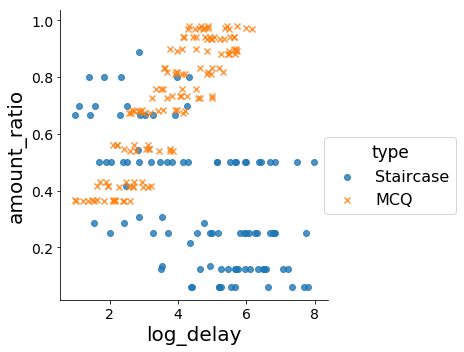

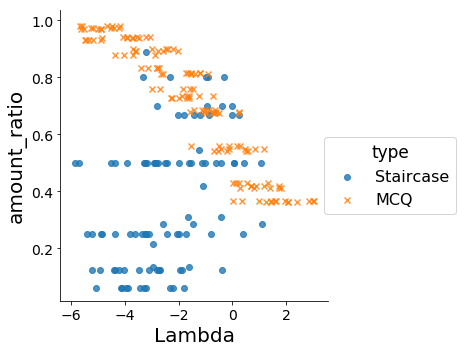

In [9]:
sns.lmplot(x='log_delay', y='amount_ratio', hue='type', data=choices, fit_reg=False, x_jitter=1, markers=['o', 'x'])
sns.lmplot(x='Lambda', y='amount_ratio', hue='type', data=choices, fit_reg=False, x_jitter=1, markers=['o', 'x'])

In [6]:
def get_indifference_point_staircase(choices, delay):
    if len(choices[~choices.ss_chosen])==0:
        ip = 0
    elif len(choices[choices.ss_chosen])==0:
        ip = 1
    else:
        ip = (choices[choices.ss_chosen].amount_ratio.min() 
                + choices[~choices.ss_chosen].amount_ratio.max())/2
    return ip

def get_indiff_point_sc(choices_sc):
    indiff_points = (choices_sc.groupby(['subj_id', 'll_delay'])
                     .apply(lambda c: get_indifference_point_staircase(c, c.iloc[0].ll_delay))
                     .rename('indiff_point'))
    return indiff_points

def get_delta_staircase(choices_sc):
    indiff_points = get_indiff_point_sc(choices_sc)
    choices_sc = choices_sc.join(indiff_points, on=['subj_id', 'll_delay'])
    choices_sc['delta'] = abs(choices_sc['amount_ratio'] - choices_sc['indiff_point'])
    choices_sc['log_delta'] = np.log(choices_sc['delta'])
    choices_sc['delta_quartile'] = pd.cut(choices_sc.delta, 
                                        choices_sc.delta.quantile([0, 0.25, 0.5, 0.75, 1]), 
                                        labels=[1, 2, 3, 4])
    return choices_sc


choices_sc = get_delta_staircase(choices_sc)

In [7]:
ip = get_indiff_point_sc(choices_sc)
choices_sc.groupby(['subj_id', 'ss_chosen']).count().iloc[:,0]

subj_id  ss_chosen
337      False         8
         True         12
502      False         4
         True         16
660      False         8
         True         12
691      False         7
         True         13
967      False         5
         True         11
Name: is_staircase, dtype: int64

In [8]:
def get_k(indiff_points):
    print(indiff_points)
    delays = indiff_points.index.get_level_values('ll_delay').values
    delays /= max(delays)
    values = indiff_points.values
    k = 1 - ((delays[1:]-delays[:-1])*(values[:-1]+values[1:])/2)
    
    return k.sum()
    
ip.groupby('subj_id').apply(get_k)

subj_id  ll_delay 
337      7.000       0.683
         30.000      0.404
         183.000     0.093
         365.000     0.093
         1,095.000   0.093
Name: 337, dtype: float64
subj_id  ll_delay 
502      7.000       0.750
         30.000      0.459
         183.000     0.000
         365.000     0.000
         1,095.000   0.000
Name: 502, dtype: float64
subj_id  ll_delay 
660      7.000       0.606
         30.000      0.845
         183.000     0.232
         365.000     0.093
         1,095.000   0.000
Name: 660, dtype: float64
subj_id  ll_delay 
691      7.000       0.683
         30.000      0.750
         183.000     0.093
         365.000     0.129
         1,095.000   0.000
Name: 691, dtype: float64
subj_id  ll_delay 
967      7.000       1.000
         30.000      0.192
         183.000     0.000
         365.000     0.000
         1,095.000   0.000
Name: 967, dtype: float64


subj_id
337   3.876
502   3.955
660   3.851
691   3.865
967   3.974
Name: indiff_point, dtype: float64